<a href="https://colab.research.google.com/github/GiackAloZ/di-playstore/blob/master/play-store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto di DI - Google Play Store: Category Classification

Questo progetto prende in esame un dataset ottenuto dal Google Play Store, dove sono state collezionate le informazioni riguardanti piu' di 10.000 app.

Lo scopo del progetto e' quello di utilizzare semplici tecniche di NLP per classificare una app nella sua categoria (eg. Game, Social, Art & Design, etc...) a partire dal suo nome.

Ho trovato il dataset su Kaggle ed e' consultabile [qui](https://www.kaggle.com/lava18/google-play-store-apps).



## Descrizione del problema e analisi esplorativa

Si deve realizzare un modello che, dato il nome di una app, la classifichi in base alla sua categoria tra le varie disponibili (eg. Game, Social, Art & Design, etc...)

Per prima cosa, importiamo le librerie che ci serviranno.

In [8]:
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! mv kaggle.json ~/.kaggle
# ! chmod 600 ~/.kaggle/kaggle.json

In [9]:
import os

import numpy as np
import pandas as pd
import sklearn as skl
import tensorflow.keras as ks
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import kaggle

from sklearn.feature_extraction.text import CountVectorizer

Scarichiamo il dataset da kaggle (se non e' gia' presente nella repo o in Colab)

In [10]:
! kaggle datasets download -d lava18/google-play-store-apps
! unzip -n google-play-store-apps.zip

  0% 0.00/1.94M [00:00<?, ?B/s]
100% 1.94M/1.94M [00:00<00:00, 64.6MB/s]
Archive:  google-play-store-apps.zip
  inflating: googleplaystore.csv     
  inflating: googleplaystore_user_reviews.csv  
  inflating: license.txt             


Carichiamo i dati dal csv `googleplaystore.csv` come un dataframe pandas e diamo un'occhiata alla sua shape e alle prime 5 righe.

In [11]:
apps_data = pd.read_csv("googleplaystore.csv")
print(apps_data.shape)
apps_data.head(5)

(10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Ci sono numerose informazioni in questo dataset, ma le colonne che andremo a considerare sono due:

- `App`, ovvero i nomi delle app
- `Category`, la categoria a cui appartiene ogni app

Andiamo a osservare quali possono essere le categorie a cui un'applicazione puo' appartenere.

In [12]:
apps_data["Category"].value_counts()

FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
AUTO_AND_VEHICLES        85
LIBRARIES_AND_DEMO       85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
COMICS                   60
PARENTING                60
BEAUTY                   53
1.9                       1
Name: Category, dtype: int64

C'e' una categoria che probabilemente e' stata inserita per errore, cioe' la categoria identificata con il nome "1.9", perche' ha una sola occorrenza. Andiamo a vedere di cosa si tratta.

In [13]:
wrong_data = apps_data[apps_data["Category"] == "1.9"]
wrong_data

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


Sembrerebbe un dato errato, infatti ha tutte le colonne sbagliate o shiftate. Possiamo rimuoverla dal dataset.

In [14]:
apps_data = apps_data[~apps_data.index.isin(wrong_data.index)].reset_index()

Andiamo ora a visualizzare le categorie in un grafico a barre

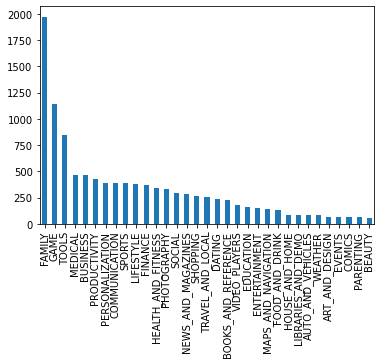

In [15]:
apps_data["Category"].value_counts().plot.bar()

Notiamo che le categorie spaziano da molto popolate (eg. FAMILY o GAME) a scarsamente popolate (eg. COMICS o BEAUTY).
Questo potrebbe causare problemi durante la fase di apprendimento, ma per adesso ci puo' andare bene.

Vogliamo ora farci un'idea di come sono fatti i nomi delle app. Per fare cio', andiamo a concatenare tutti i nomi in una string `text` per poi creare una `cloudword` di tutti i nomi delle app in modo da osservare a colpo d'occhio quali sono le parole che compaiono piu' spesso.

In [16]:
text = " ".join(apps_data["App"])

In [17]:
wc = wordcloud.WordCloud(
    width=800, height=800,
    background_color="white", max_words=200
).generate(text)

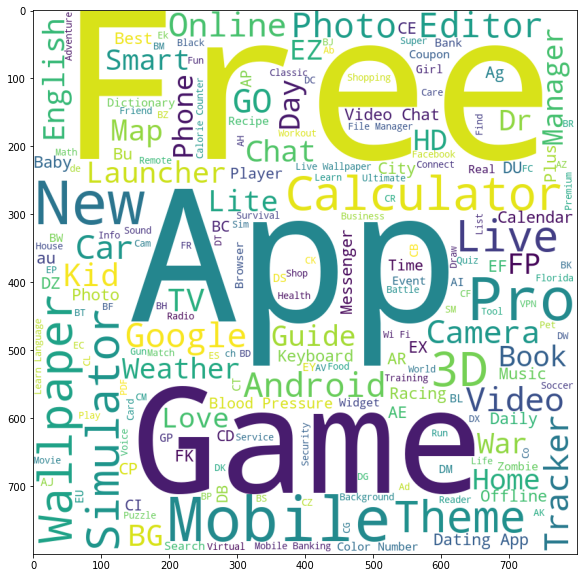

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(wc)

Notiamo subito che le parole piu' utilizzate sono quelle che ci potevamo aspettare, come "App" o "Mobile" oppure anche "Free".